# 課題5
* モデルやoptimizerやその学習率を変更して、validation setを使ってチューニングしよう。
* その際、lossの値も監視するようにしようしよう
* 最後に、自分で選択した設定を使って、test set上で評価しよう。

## 準備

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import drive
from matplotlib import pyplot as plt

np.random.seed(123)
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

In [3]:
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/NLP/data/imdb/'

texts = {}
labels = {}
for tag in ['train', 'test']:
  with open(f'{PATH}{tag}.npy', 'rb') as f:
    texts[tag] = np.load(f)
  with open(f'{PATH}{tag}_labels.npy', 'rb') as f:
    labels[tag] = np.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
for tag in ['train', 'test']:
  print(tag, texts[tag].shape)

train (25000, 300)
test (25000, 300)


* PyTorchのテンソルに変換しておく。

In [5]:
for tag in ['train', 'test']:
  texts[tag] = torch.tensor(texts[tag])
  labels[tag] = torch.tensor(labels[tag])

### Dataset

In [6]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [7]:
train_dataset = MyDataset(texts['train'], labels['train'])
test_dataset = MyDataset(texts['test'], labels['test'])

valid_size = len(train_dataset) // 5
train_size = len(train_dataset) - valid_size
split_train_, split_valid_ = random_split(train_dataset, [train_size, valid_size])

### DataLoader

In [8]:
BATCH_SIZE = 64

train_loader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(split_valid_, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### 訓練を行なう関数

In [9]:
def train(dataloader):
  model.train()

  total_acc = 0.0
  total_count = 0
  for input, target in dataloader:
    input, target = input.to(device), target.to(device)
    output = model(input)
    loss = criterion(output, target)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    total_acc += (output.argmax(1) == target).sum().item()
    total_count += len(target) # 表示用の集計
  return total_acc / total_count

### 評価を行なう関数
* 正解率で評価する関数を定義しておく。

In [10]:
def evaluate(dataloader):
  model.eval()
  total_acc = 0.0
  total_count = 0

  # 損失値
  total_loss = 0.0

  for input, target in dataloader:
    with torch.no_grad():
      input, target = input.to(device), target.to(device)
      output = model(input)

      # 損失値考査
      loss = criterion(output, target)
      total_loss += (loss * len(target)).detach().cpu().numpy()

      total_acc += (output.argmax(1) == target).sum().item()
      total_count += len(target)
  return total_acc / total_count, total_loss / total_count

### 損失関数と最適化アルゴリズム

In [11]:
criterion = torch.nn.CrossEntropyLoss()

# チューニング
# ①学習率:[0.01, 0.001, 0.0001, 0.00001]
# ②UNITS:[2056, 1028, 512, 216]
# ③Lay数：3, 4, 5
def getOptimizer(model, lr=0.0001):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  return optimizer

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,50], gamma=0.1)

## 学習率のチューニング：

### モデルの定義

In [12]:
class TextSentiment(nn.Module):
  def __init__(self, emsize, num_class):
    super(TextSentiment, self).__init__()
    self.fc1 = nn.Linear(emsize, 500)
    self.fc2 = nn.Linear(500, 100)
    self.fc3 = nn.Linear(100, num_class)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [13]:
EMSIZE = texts['train'].size(1) # 埋め込みベクトルの次元
NUM_CLASS = len(np.unique(labels['train'])) # クラスの個数

# model = TextSentiment(EMSIZE, NUM_CLASS).to(device)

### 訓練と評価の実施

In [14]:
EPOCHS = 100
lrList = [0.01, 0.001, 0.0001, 0.00001]

# 考査用リスト
valid_acc_list_lr, valid_acc_list_mean_lr = [], []
valid_los_list_lr, valid_los_list_mean_lr = [], []

for lr in lrList:
  print(f'======learning rate {lr} START===== ')

  # モデル初期化
  model = TextSentiment(EMSIZE, NUM_CLASS).to(device)

  # optimizer生成
  optimizer = getOptimizer(model, lr)

  for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_acc = train(train_loader)
    valid_acc = evaluate(valid_loader)

    # Validデータの学習率のスーコア
    valid_acc_list_lr.append(valid_acc[0])
    valid_los_list_lr.append(valid_acc[1])

    print(f'epoch {epoch:3d} | '
          f'time: {time.time() - epoch_start_time:5.2f}s | '
          f'train accuracy {train_acc:5.3f} | '
          f'valid accuracy {valid_acc[0]:5.3f} | '
          f'valid loss {valid_acc[1]:5.3f} | ')

  # Validデータの学習率の平均スーコア
  valid_acc_list_mean_lr.append(np.mean(valid_acc_list_lr))
  valid_los_list_mean_lr.append(np.mean(valid_los_list_lr))

  print(f'mean valid accuracy {np.mean(valid_acc_list_mean_lr):5.3f} | '
        f'mean valid loss {np.mean(valid_los_list_mean_lr):5.3f} | ')

======learning rate 0.01 START===== 
epoch   1 | time:  1.39s | train accuracy 0.791 | valid accuracy 0.770 | valid loss 0.494 | 
epoch   2 | time:  0.72s | train accuracy 0.832 | valid accuracy 0.851 | valid loss 0.346 | 
epoch   3 | time:  0.72s | train accuracy 0.845 | valid accuracy 0.824 | valid loss 0.387 | 
epoch   4 | time:  0.89s | train accuracy 0.847 | valid accuracy 0.852 | valid loss 0.347 | 
epoch   5 | time:  1.40s | train accuracy 0.847 | valid accuracy 0.800 | valid loss 0.420 | 
epoch   6 | time:  1.24s | train accuracy 0.849 | valid accuracy 0.855 | valid loss 0.341 | 
epoch   7 | time:  1.22s | train accuracy 0.851 | valid accuracy 0.846 | valid loss 0.359 | 
epoch   8 | time:  1.43s | train accuracy 0.850 | valid accuracy 0.849 | valid loss 0.351 | 
epoch   9 | time:  1.55s | train accuracy 0.850 | valid accuracy 0.853 | valid loss 0.349 | 
epoch  10 | time:  1.41s | train accuracy 0.859 | valid accuracy 0.859 | valid loss 0.334 | 
epoch  11 | time:  1.30s | train 

### 考査

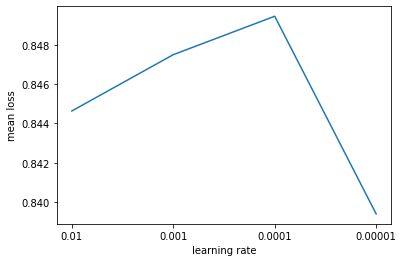

In [15]:
x_lr = [1, 2, 3, 4]
plt.plot(x_lr, valid_acc_list_mean_lr)
plt.xlabel("learning rate")
plt.ylabel("mean loss")
plt.xticks(x_lr, ["0.01", "0.001", "0.0001", "0.00001"])
plt.show()

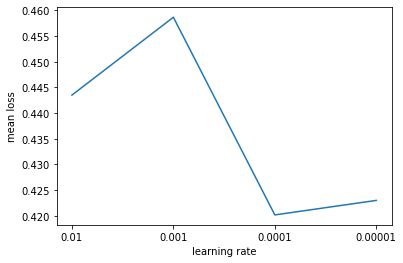

In [16]:
plt.plot(x_lr, valid_los_list_mean_lr)
plt.xlabel("learning rate")
plt.ylabel("mean loss")
plt.xticks(x_lr, ["0.01", "0.001", "0.0001", "0.00001"])
plt.show()

In [17]:
## 学習率[0.0001]の場合、平均スーコアは一番高いです。
## 学習率[0.00001]の場合、平均損失値は一番低いですが、平均スーコアも一番低いです。
## なので、学習率[0.0001]を設定し、他のチューニングを進めます。

## モデルのUNITSのチューニング

### モデルの定義

In [18]:
class TextSentimentUnits(nn.Module):
  # モデルUNITSのチューニング
  # [2056, 1028, 512, 216]
  def __init__(self, emsize, units, num_class):
    super(TextSentimentUnits, self).__init__()
    self.fc1 = nn.Linear(emsize, units)
    self.fc2 = nn.Linear(units, 100)
    self.fc3 = nn.Linear(100, num_class)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [19]:
# モデル初期化
def unitsTuning(units):
  model = TextSentimentUnits(EMSIZE, units, NUM_CLASS).to(device)
  return model

### 訓練と評価の実施

In [20]:
EPOCHS = 100
unitsList = [2056, 1028, 512, 216]
valid_acc_list_units, valid_acc_list_mean_units = [], []
valid_los_list_units, valid_los_list_mean_units = [], []

for units in unitsList:
  print(f'======units {units} START===== ')

  # unitsのチューニング
  model = unitsTuning(units)

  # optimizer生成
  optimizer = getOptimizer(model)

  for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_acc = train(train_loader)
    valid_acc = evaluate(valid_loader)

    valid_acc_list_units.append(valid_acc[0])
    valid_los_list_units.append(valid_acc[1])

    print(f'epoch {epoch:3d} | '
          f'time: {time.time() - epoch_start_time:5.2f}s | '
          f'train accuracy {train_acc:5.3f} | '
          f'valid accuracy {valid_acc[0]:5.3f} | '
          f'valid loss {valid_acc[1]:5.3f} | ')

  valid_acc_list_mean_units.append(np.mean(valid_acc_list_units))
  valid_los_list_mean_units.append(np.mean(valid_los_list_units))

  print(f'mean valid accuracy {np.mean(valid_acc_list_mean_units):5.3f} | '
        f'mean valid loss {np.mean(valid_los_list_mean_units):5.3f} | ')

======units 2056 START===== 
epoch   1 | time:  0.74s | train accuracy 0.658 | valid accuracy 0.749 | valid loss 0.552 | 
epoch   2 | time:  0.73s | train accuracy 0.799 | valid accuracy 0.823 | valid loss 0.411 | 
epoch   3 | time:  0.74s | train accuracy 0.828 | valid accuracy 0.834 | valid loss 0.382 | 
epoch   4 | time:  0.74s | train accuracy 0.838 | valid accuracy 0.837 | valid loss 0.375 | 
epoch   5 | time:  0.74s | train accuracy 0.840 | valid accuracy 0.840 | valid loss 0.367 | 
epoch   6 | time:  0.73s | train accuracy 0.846 | valid accuracy 0.849 | valid loss 0.356 | 
epoch   7 | time:  0.79s | train accuracy 0.848 | valid accuracy 0.850 | valid loss 0.352 | 
epoch   8 | time:  0.73s | train accuracy 0.852 | valid accuracy 0.846 | valid loss 0.354 | 
epoch   9 | time:  0.73s | train accuracy 0.852 | valid accuracy 0.853 | valid loss 0.349 | 
epoch  10 | time:  0.74s | train accuracy 0.853 | valid accuracy 0.850 | valid loss 0.346 | 
epoch  11 | time:  0.73s | train accuracy

### 考査

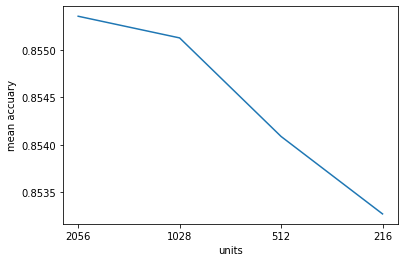

In [21]:
x_units = [1, 2, 3, 4]
plt.plot(x_units, valid_acc_list_mean_units)
plt.xlabel("units")
plt.ylabel("mean accuary")
plt.xticks(x_units, ["2056", "1028", "512", "216"])
plt.show()

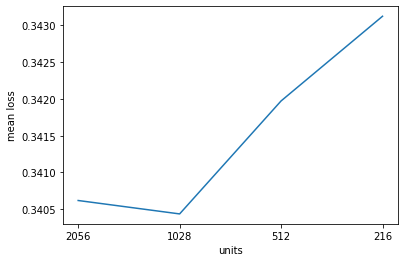

In [22]:
plt.plot(x_units, valid_los_list_mean_units)
plt.xlabel("units")
plt.ylabel("mean loss")
plt.xticks(x_units, ["2056", "1028", "512", "216"])
plt.show()

In [23]:
## UNITSは変わるにつれて、平均スーコアと損失率も変わりました。
## かくUNITSの結果には、平均スーコアは0.85ぐらい、平均損失値はは0.34ぐらいです。差はそんな多くないです。
## では、UNITSは2056を設定して、次のチューニングを行う。

## モデルのLAYのチューニング

### モデルの定義

In [24]:
# LAYのチューニング
# ３層
class TextSentimentLay3(nn.Module):
  def __init__(self, emsize, num_class):
    super(TextSentimentLay3, self).__init__()
    self.fc1 = nn.Linear(emsize, 2056)
    self.fc2 = nn.Linear(2056, 128)
    self.fc3 = nn.Linear(128, num_class)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [25]:
# LAYのチューニング
# ４層
class TextSentimentLay4(nn.Module):
  def __init__(self, emsize, num_class):
    super(TextSentimentLay4, self).__init__()
    self.fc1 = nn.Linear(emsize, 512)
    self.fc2 = nn.Linear(512, 2056)
    self.fc3 = nn.Linear(2056, 128)
    self.fc4 = nn.Linear(128, num_class)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [26]:
# LAYのチューニング
# ５層
class TextSentimentLay5(nn.Module):
  def __init__(self, emsize, num_class):
    super(TextSentimentLay5, self).__init__()
    self.fc1 = nn.Linear(emsize, 512)
    self.fc2 = nn.Linear(512, 1024)
    self.fc3 = nn.Linear(1024, 2056)
    self.fc4 = nn.Linear(2056, 128)
    self.fc5 = nn.Linear(128, num_class)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [27]:
# モデル初期化
model_lay3 = TextSentimentLay3(EMSIZE, NUM_CLASS).to(device)
model_lay4 = TextSentimentLay4(EMSIZE, NUM_CLASS).to(device)
model_lay5 = TextSentimentLay5(EMSIZE, NUM_CLASS).to(device)

### 訓練と評価の実施

In [28]:
EPOCHS = 100
valid_acc_list_lay, valid_acc_list_mean_lay = [], []
valid_los_list_lay, valid_los_list_mean_lay = [], []

# i=0, TextSentimentLay3
# i=1, TextSentimentLay4
# i=2, TextSentimentLay5
for i in range(0, 3):

  # layのチューニング
  if i == 0:
    model = model_lay3
    print(f'======model_lay3 STRAT===== ')
  elif i == 1:
    model = model_lay4
    print(f'======model_lay4 STRAT===== ')
  else:
    model = model_lay5
    print(f'======model_lay5 STRAT===== ')

  # optimizer生成
  optimizer = getOptimizer(model)

  for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_acc = train(train_loader)
    valid_acc = evaluate(valid_loader)

    valid_acc_list_lay.append(valid_acc[0])
    valid_los_list_lay.append(valid_acc[1])
    
    print(f'epoch {epoch:3d} | '
          f'time: {time.time() - epoch_start_time:5.2f}s | '
          f'train accuracy {train_acc:5.3f} | '
          f'valid accuracy {valid_acc[0]:5.3f} | '
          f'valid loss {valid_acc[1]:5.3f} | ')

  valid_acc_list_mean_lay.append(np.mean(valid_acc_list_lay))
  valid_los_list_mean_lay.append(np.mean(valid_los_list_lay))

  print(f'mean valid accuracy {np.mean(valid_acc_list_lay):5.3f} | '
        f'mean valid loss {np.mean(valid_los_list_lay):5.3f} | ')

======model_lay3 STRAT===== 
epoch   1 | time:  0.73s | train accuracy 0.656 | valid accuracy 0.775 | valid loss 0.524 | 
epoch   2 | time:  0.73s | train accuracy 0.809 | valid accuracy 0.829 | valid loss 0.401 | 
epoch   3 | time:  0.75s | train accuracy 0.829 | valid accuracy 0.840 | valid loss 0.378 | 
epoch   4 | time:  0.74s | train accuracy 0.837 | valid accuracy 0.841 | valid loss 0.369 | 
epoch   5 | time:  0.74s | train accuracy 0.844 | valid accuracy 0.848 | valid loss 0.359 | 
epoch   6 | time:  0.71s | train accuracy 0.846 | valid accuracy 0.834 | valid loss 0.374 | 
epoch   7 | time:  0.73s | train accuracy 0.851 | valid accuracy 0.851 | valid loss 0.349 | 
epoch   8 | time:  0.74s | train accuracy 0.852 | valid accuracy 0.846 | valid loss 0.354 | 
epoch   9 | time:  0.72s | train accuracy 0.853 | valid accuracy 0.841 | valid loss 0.356 | 
epoch  10 | time:  0.73s | train accuracy 0.854 | valid accuracy 0.854 | valid loss 0.343 | 
epoch  11 | time:  0.72s | train accuracy

### 考査

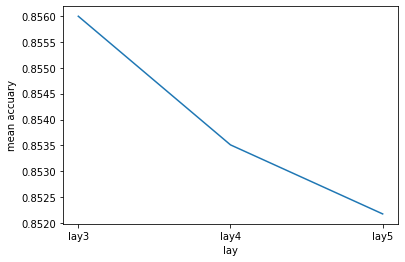

In [29]:
x_lay = [3,4,5]
plt.plot(x_lay, valid_acc_list_mean_lay)
plt.xlabel("lay")
plt.ylabel("mean accuary")
plt.xticks(x_lay, ["lay3", "lay4", "lay5"])
plt.show()

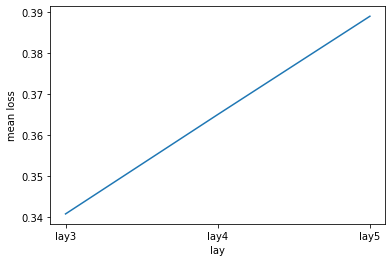

In [30]:
plt.plot(x_lay, valid_los_list_mean_lay)
plt.xlabel("lay")
plt.ylabel("mean loss")
plt.xticks(x_lay, ["lay3", "lay4", "lay5"])
plt.show()

In [31]:
## ３層の構造には、平均スーコアは一番高いです、損失スーコアも一番低いです

## テストデータの評価

* ハイパーパラメータのチューニングが済んだら、テストセットで評価する。

In [32]:
# モデル選定
# 学習率：0.00001、モデルのUNITS：2056、LAY：３層
model = model_lay3

In [33]:
test_acc = evaluate(test_loader)
print(f'valid accuracy {test_acc[0]:5.3f} | '
      f'valid loss {test_acc[1]:5.3f} | ')

valid accuracy 0.850 | valid loss 0.356 | 
